In [4]:
%pip install pylatexenc


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Qiskit Version: 2.2.3

[1] 建構 ZZ-Feature Map (Qubits=4)...
說明: H閘創造疊加態，Rz與CNOT閘創造糾纏與資料編碼


/var/folders/8q/j_629p_55k75hcy496bd95p00000gn/T/ipykernel_90051/1372303984.py:26: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2, entanglement='linear')


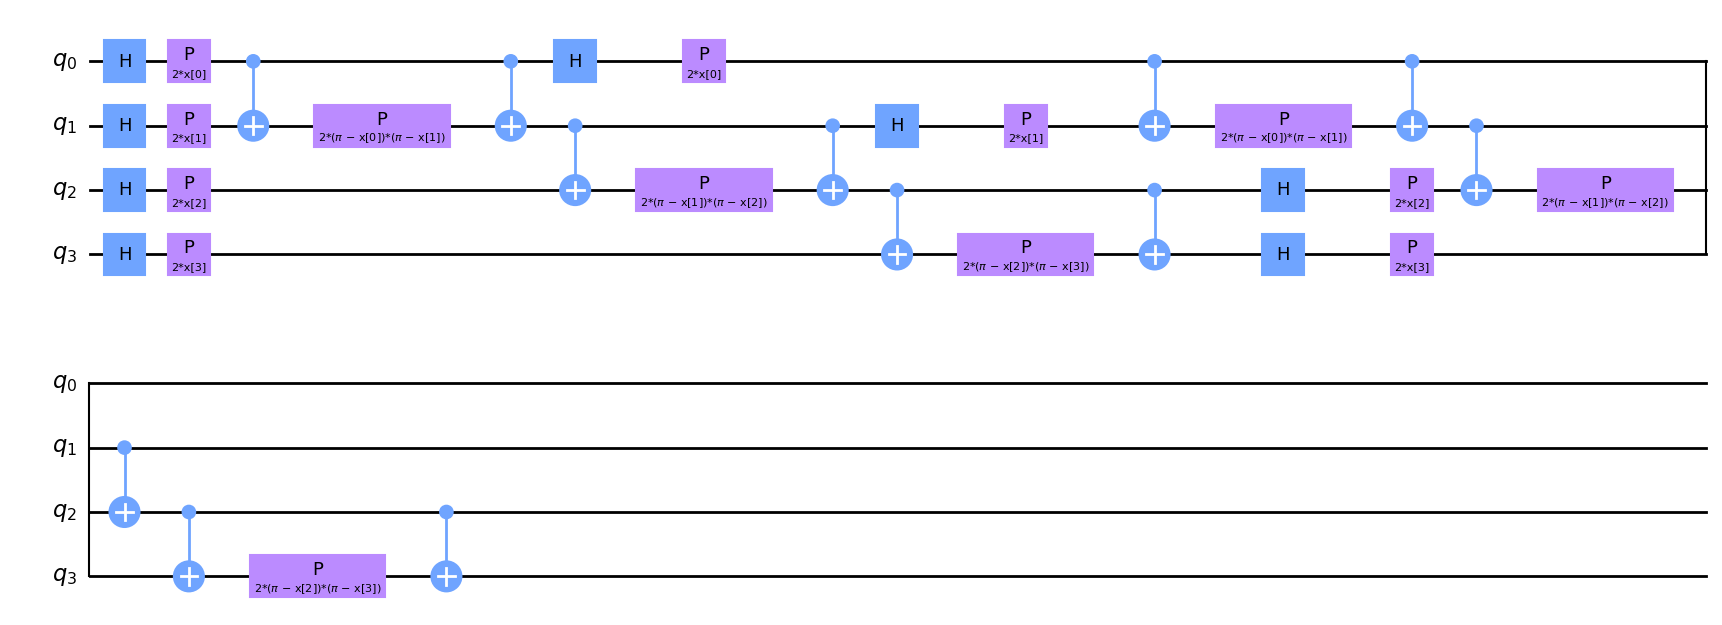


[2] 建構變分量子線路 (Ansatz)...
說明: 這裡的 Ry(θ) 包含了模型需要學習的權重


/var/folders/8q/j_629p_55k75hcy496bd95p00000gn/T/ipykernel_90051/1372303984.py:42: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement='linear')


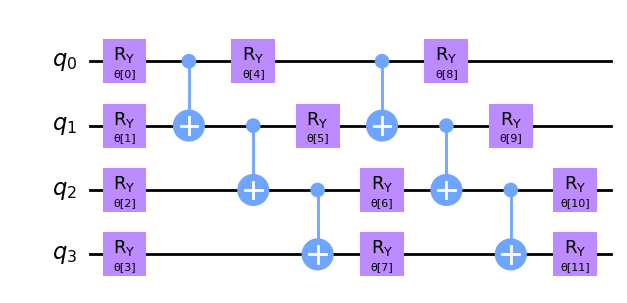


[3] 串接完整電路 (Feature Map + Ansatz)...
完整電路總參數數量 (θ): 16
這 16 個參數將透過 SPSA 優化器在訓練過程中更新 [Source 92]。


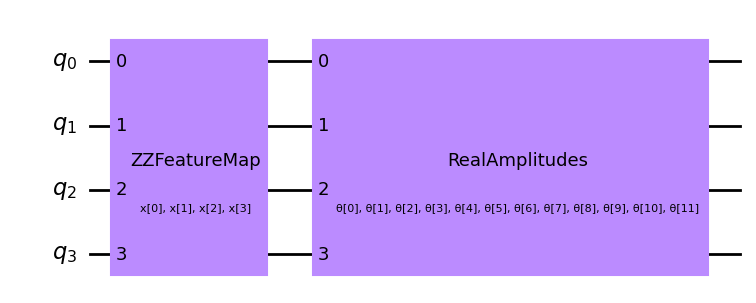


[4] 模擬資料綁定測試...
模擬輸入 x: [0.29910192 0.56249236 0.38991742 0.42048032]
資料綁定成功！準備進入量子模擬器運算...


In [2]:
# ==============================================================================
# 02_Quantum_Circuit_Demo.ipynb
# ==============================================================================
# 本 Notebook 展示 Hybrid QGNN 中的核心量子電路設計
# 對應計畫書章節: 5.3 模組三：量子核心運算層 [Source 55]

import qiskit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

# 設定繪圖風格
print(f"Qiskit Version: {qiskit.__version__}")

# ==============================================================================
# 1. 量子特徵映射 (Quantum Feature Map)
# ==============================================================================
# 根據 Havlíček et al. (2019) 與計畫書 [Source 57, 83]
# 我們使用 ZZ-Feature Map 將古典資料映射至高維希爾伯特空間。
# 這種映射利用量子糾纏 (Entanglement) 來處理非線性分離問題。

n_qubits = 4  # 對應壓縮後的特徵維度 N=4 [Source 54]
print(f"\n[1] 建構 ZZ-Feature Map (Qubits={n_qubits})...")

# reps=2 代表電路重複堆疊兩層，增加糾纏深度
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2, entanglement='linear')

# 繪製電路圖
print("說明: H閘創造疊加態，Rz與CNOT閘創造糾纏與資料編碼")
#feature_map.decompose().draw(output='mpl', style='clifford')
#plt.show()
fig1 = feature_map.decompose().draw(output='mpl', style='clifford')
display(fig1)

# ==============================================================================
# 2. 變分量子線路 (Variational Ansatz)
# ==============================================================================
# 這是模型可訓練的部分，包含參數 θ (Theta) [Source 58, 87]。
# 我們使用 RealAmplitudes 架構，由旋轉閘 Ry 與 CNOT 組成。

print(f"\n[2] 建構變分量子線路 (Ansatz)...")
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement='linear')

# 繪製電路圖
print("說明: 這裡的 Ry(θ) 包含了模型需要學習的權重")
#ansatz.decompose().draw(output='mpl', style='clifford')
#plt.show()
fig2 = ansatz.decompose().draw(output='mpl', style='clifford')
display(fig2)

# ==============================================================================
# 3. 完整的混合量子電路 (Composed Circuit)
# ==============================================================================
# 將特徵映射與變分線路串接，形成完整的量子分類器
# Data Encoding -> Trainable Layers -> Measurement

print(f"\n[3] 串接完整電路 (Feature Map + Ansatz)...")
full_circuit = feature_map.compose(ansatz)

# 顯示參數資訊
num_params = full_circuit.num_parameters
print(f"完整電路總參數數量 (θ): {num_params}")
print(f"這 {num_params} 個參數將透過 SPSA 優化器在訓練過程中更新 [Source 92]。")

# 繪製完整架構
#full_circuit.draw(output='mpl', style='clifford')
#plt.show()
fig3 = full_circuit.draw(output='mpl', style='clifford')
display(fig3)

# ==============================================================================
# 4. 參數綁定測試 (Parameter Binding Check)
# ==============================================================================
# 模擬一筆輸入資料 x，確認電路能正確接收資料

print(f"\n[4] 模擬資料綁定測試...")
# 模擬一筆經由 GraphSAGE 壓縮後的 4維特徵向量 x
dummy_input_x = np.random.rand(n_qubits)
print(f"模擬輸入 x: {dummy_input_x}")

# 將資料綁定到 Feature Map 的參數上
# 注意：Ansatz 的參數 θ 這裡先保持變數狀態，因為訓練時才會更新
bound_circuit = full_circuit.assign_parameters(
    {param: val for param, val in zip(feature_map.parameters, dummy_input_x)}
)

print("資料綁定成功！準備進入量子模擬器運算...")